# Using the `fst` Module

For several of the homework assignments in this course, we're providing the `fst` module for finite-state transducers. It's lightweight, so that it's not too difficult to understand, modify, or reimplement (if you choose to use a different programming language or just like writing your own code).

To use the module, just import it:

In [1]:
import fst

## Creating and inspecting an FST

The module comes with just one example of how to create a FST. (It's your job to create the rest.) The function `fst.string` takes a sequence `w` of symbols and creates the FST that accepts the language `{w}` mapping `w` to itself.

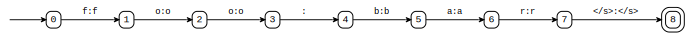

In [2]:
fst.string("foo bar")

In a Jupyter notebook, `FST`s are shown as graphs, as above. The above line is equivalent to:

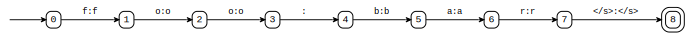

In [3]:
w = "foo bar"
m_w = fst.FST()
m_w.set_start(0)
for i, a in enumerate(w):
    m_w.add_transition(fst.Transition(i, a, a, i+1))
m_w.add_transition(fst.Transition(len(w), fst.STOP, fst.STOP, len(w)+1))
m_w.set_accept(len(w)+1)
m_w

Note that:
- a symbol can be any hashable object, but is usually a `str`
- a state can be any hashable object; `int`s, `str`s, `tuple`s are all okay.
- `Transition(q, a, b, r)` creates a transition from state `q` to state `r` while reading `a` and writing `b`. A `Transition` is hashable.
- If `m` is a `FST`, `m.set_start(q)` sets it start state to `q`.
- There is at most one accept state, set using `m.set_accept(q)`.
- `STOP` is a special symbol (`"</s>"`) used to mark the end of the string
- `EPSILON` is a special symbol (`"ε"`) for the empty string.

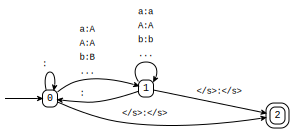

In [4]:
titlecaser = fst.FST()
titlecaser.set_start(0)
alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
for a in alphabet:
    titlecaser.add_transition(fst.Transition(0, a,         a.upper(), 1))
    titlecaser.add_transition(fst.Transition(0, a.upper(), a.upper(), 1))
    titlecaser.add_transition(fst.Transition(0, ' ',       ' ',       0))
    titlecaser.add_transition(fst.Transition(0, fst.STOP,  fst.STOP,  2))
    titlecaser.add_transition(fst.Transition(1, a,         a,         1))
    titlecaser.add_transition(fst.Transition(1, a.upper(), a.upper(), 1))
    titlecaser.add_transition(fst.Transition(1, ' ',       ' ',       0))
    titlecaser.add_transition(fst.Transition(1, fst.STOP,  fst.STOP,  2))
titlecaser.set_accept(2)
titlecaser

(If there are many parallel transitions, only three random ones are shown with a `...`.)

The transitions can be accessed via the `transitions` attribute, which is a dict of dicts. If `m` is a `FST`, then `transitions[q][a]` contains the transitions from state `q` reading input `a`.

In [5]:
titlecaser.transitions[0]['a']

{Transition(q=0, a='a', b='A', r=1)}

## Weights

An `FST` object `m` stores the count of transition `t` in `m.counts[t]`. By default, `m.add_transition(t)` increments the count of `t` by 1; `m.add_transition(t, c)` increments it by `c` instead.

The `FST` class does not store any other weights. This may seem inconvenient, but there are many ways of defining and using weights, and it seemed best to separate them out.

To make a weighted FST, create a `dict` (or something similar, like a `defaultdict` or `Counter`) mapping from `Transition`s to weights. You can put it inside the `FST` object or leave it outside. We define a little helper function to reduce typing:

In [6]:
import collections

titlecaser = fst.FST()
titlecaser.weights = collections.defaultdict(float)
titlecaser.set_start(0)

def add_transition(q, a, b, r, wt):
    t = fst.Transition(q, a, b, r)
    titlecaser.add_transition(t)
    titlecaser.weights[t] += wt
    
alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
for a in alphabet:
    add_transition(0, a,         a.upper(), 1, 0.8)
    add_transition(0, a,         a        , 1, 0.2)
    add_transition(0, a.upper(), a.upper(), 1, 1  )
    add_transition(0, ' ',       ' ',       0, 1  )
    add_transition(0, fst.STOP,  fst.STOP,  2, 1  )
    add_transition(1, a,         a,         1, 1  )
    add_transition(0, a.upper(), a.upper(), 1, 1  )
    add_transition(1, ' ',       ' ',       0, 1  )
    add_transition(1, fst.STOP,  fst.STOP,  2, 1  )
titlecaser.set_accept(2)

## Estimating probabilities

When weights are probabilities derived from counts, `fst.estimate_joint` and `fst.estimate_cond` can convert the counts to joint (input and output) and conditional (output given input) probabilities, respectively.

In [7]:
titlecaser.probs = fst.estimate_joint(titlecaser.counts)
titlecaser.probs

{Transition(q=0, a='a', b='A', r=1): 0.00641025641025641,
 Transition(q=0, a='a', b='a', r=1): 0.00641025641025641,
 Transition(q=0, a='A', b='A', r=1): 0.01282051282051282,
 Transition(q=0, a=' ', b=' ', r=0): 0.16666666666666666,
 Transition(q=0, a='</s>', b='</s>', r=2): 0.16666666666666666,
 Transition(q=1, a='a', b='a', r=1): 0.01282051282051282,
 Transition(q=1, a=' ', b=' ', r=0): 0.3333333333333333,
 Transition(q=1, a='</s>', b='</s>', r=2): 0.3333333333333333,
 Transition(q=0, a='b', b='B', r=1): 0.00641025641025641,
 Transition(q=0, a='b', b='b', r=1): 0.00641025641025641,
 Transition(q=0, a='B', b='B', r=1): 0.01282051282051282,
 Transition(q=1, a='b', b='b', r=1): 0.01282051282051282,
 Transition(q=0, a='c', b='C', r=1): 0.00641025641025641,
 Transition(q=0, a='c', b='c', r=1): 0.00641025641025641,
 Transition(q=0, a='C', b='C', r=1): 0.01282051282051282,
 Transition(q=1, a='c', b='c', r=1): 0.01282051282051282,
 Transition(q=0, a='d', b='D', r=1): 0.00641025641025641,
 Tra

In [8]:
titlecaser.condprobs = fst.estimate_cond(titlecaser.counts)
titlecaser.condprobs

{Transition(q=0, a='a', b='A', r=1): 0.5,
 Transition(q=0, a='a', b='a', r=1): 0.5,
 Transition(q=0, a='A', b='A', r=1): 1.0,
 Transition(q=0, a=' ', b=' ', r=0): 1.0,
 Transition(q=0, a='</s>', b='</s>', r=2): 1.0,
 Transition(q=1, a='a', b='a', r=1): 1.0,
 Transition(q=1, a=' ', b=' ', r=0): 1.0,
 Transition(q=1, a='</s>', b='</s>', r=2): 1.0,
 Transition(q=0, a='b', b='B', r=1): 0.5,
 Transition(q=0, a='b', b='b', r=1): 0.5,
 Transition(q=0, a='B', b='B', r=1): 1.0,
 Transition(q=1, a='b', b='b', r=1): 1.0,
 Transition(q=0, a='c', b='C', r=1): 0.5,
 Transition(q=0, a='c', b='c', r=1): 0.5,
 Transition(q=0, a='C', b='C', r=1): 1.0,
 Transition(q=1, a='c', b='c', r=1): 1.0,
 Transition(q=0, a='d', b='D', r=1): 0.5,
 Transition(q=0, a='d', b='d', r=1): 0.5,
 Transition(q=0, a='D', b='D', r=1): 1.0,
 Transition(q=1, a='d', b='d', r=1): 1.0,
 Transition(q=0, a='e', b='E', r=1): 0.5,
 Transition(q=0, a='e', b='e', r=1): 0.5,
 Transition(q=0, a='E', b='E', r=1): 1.0,
 Transition(q=1, a='e'

## Dynamic values

Sometimes we want to create weights that are dependent on other weights. For example, if `probs` contains transition probabilities, we might also want `logprobs` containing log-probabilities. Instead of building a new dict of log-probabilities, we can use `fst.dynamic_values`:

In [9]:
import math
titlecaser.logprobs = fst.dynamic_values(lambda t: math.log(titlecaser.probs[t]))
titlecaser.logprobs

Displaying the `dynamic_values` object doesn't do much, but we can access it like a dict:

In [10]:
t = fst.Transition(0, 'a', 'A', 1)
titlecaser.probs[t]

0.00641025641025641

In [11]:
titlecaser.logprobs[t]

-5.049856007249537

And if we change a probability, the log-probability automatically updates:

In [12]:
titlecaser.probs[t] = 0.5
titlecaser.logprobs[t]

-0.6931471805599453

## Composition

Use `fst.compose` to compose two FSTs.

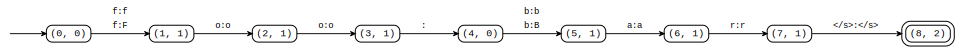

In [13]:
fst.compose(m_w, titlecaser)

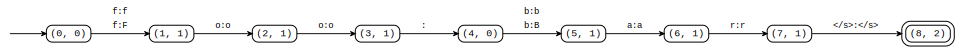

In [14]:
m = fst.compose(m_w, titlecaser)
m

The resulting `FST` has a special method `compose_values` that computes weights for the composed FST from the two component FSTs.

In [15]:
m.weights = m.compose_values(m_w.counts, titlecaser.weights)
m.weights[fst.Transition((0,0), 'f', 'F', (1,1))]

0.8

Like `dynamic_values`, `m.compose_values` recomputes weights dynamically, so that if you subsequently modify the weights of the component FSTs, the weights of the composed FST are automatically updated.

By default, the weight of a composed transition is the product of the weights of the component transitions (and if there is more than one pair of component transitions, it's the sum of the products). If you want the weight of a composed transition to be the sum of the weights of the component transitions, pass `'+'` as the third argument to `m.compose_values`.